# Robotics project 

In this project, we programed the Thymio robot to follow an optimal path to a goal position while avoiding global and local obstacles. This task requires localizing the robot through filtering using the data from proprioceptive and exteroceptive sensors.

## Members of the team 
- Olivier Charrez  (271550)
- Arthur Chevalley (283178)
- Paco Mermoud     (290469)
- Tifanny Portela  (289149)

## Imports
We created a specific "notebook_code.py" file containing the necessary code to run the examples in this report. In our project, we used the math, matplotlib, cv2, os, time, numpy, ipywidgets and tqdm libraries.

Let's start by importing all the libraries and functions from this file.

In [1]:
from code_notebook import *

## Full setup 

This section describes the experimental setup of our project. We decided to use a camera (fixed on the broom on top of the map as shown in the picture below) to localize Thymio. 
When we started the project our vision algorithm only worked from 11am to 1pm because of luminosity. To overcome this problem, we placed a lamp (halogen + LED + fluorescent) mounted on a fixed tripod on each side of the map, in order to always have the same light intensity throughout the day.

The map borders are defined by a blue strip and the goal is defined by a blue square. 
The global obstacles are polygons made out of red paper. 
The local obstacles are white 
rectangular parallelepipeds and cylinders. 
Hence, the 2D global obstacles and 3D local obstacles.
Finally, in order to determine the position of the robot, we put a yellow and green rectangle on its top.


The following picture shows the full setup.


![full](full_setup.jpg)



## Map description

The X and Y axis of our map are defined as shown in the previous picture. The map has a width of 80 cm (along the X-axis and without the blue strips) and a length of 72.5 cm  (along the Y-axis and without the blue strips).

In order to determine the optimal path to the goal, we discretized this map into a grid map with squared cells of size 2.5 cm. Hence, this grid map has 32 cells along the X-axis and  29 cells along the Y-axis.

## Introduction

In this project, 5 components are required :
- Vision 
- Global Navigation 
- Motion Control 
- Filtering 
- Local Navigation 

In the further chapters of this notebook, we'll briefly present how we incorporated them into the project. And we'll finish by explaining the global architecture of our code.

# Vision


At the beginning of the programm, we used a vision algorithm to determine the initial pose of the robot, the goal and the obstacles.

In order to do so, we used the following pseudo-code for the vision intialization:
1. Find the blue frame delimiting the map and crop it to return a map of the world
2. Rotate the map if needed to have the correct map orientation
3. Find the global obstacles and place them in a grid for further computations
4. Find the goal position in the map's coordinates
5. Find Thymio's pose in the map's coordinates


To execute the first step, we applied a blue mask to isolate the frame. To this end, we transformed the image from RGB to HSV to have more robust masks. 
Once this step is done, we need to crop and rotate the image to keep only Thymio's map in this image. For that, we used the opencv findContour function to find the contours. As the blue mask only contains the outside frame and the goal, it will find two or more contours (as the cable connecting Thymio to the computer cuts the frame multiple times). In order to only keep the outside contours, we computed the biggest area contained inside the contours using contourArea. Then, we computed the smallest rotated rectangle containing our biggest contour and found his vertices using minAreaRect and boxPoints. From those we could compute the center of the rectangle using the diagonals and the rotation matrix given by minAreaRect. 
Finally, we rotated the map with warpAffine using the rotation matrix and cropped the result to the correct size.

The third step of the pseudo-code detects the global obstacles and places them in a grid. To accomplish that, we took the corrected map from steps 1 and 2 and resized it to the wanted grid size. As we didn't want the frame to be shown on the grid, we filtered it using a sharp kernel with high importance of the pixel in the center of the kernel and low importance to the surrounding pixels. Finally we resized the image to the desired grid size using a pixel_area interpolation which took into account the surrounding pixels. Finally, to detect the obstacles we changed the grid to HSV values and applied a red mask. After a normalization step, we had a grid with the same size as the world grid map containing all obstacles. 

The fourth step was like the third one except that we applied a blue mask on the resized map to find the goal coordinates.

The last vision step computed Thymio's pose. To find Thymio's coordinates, we repeated the first step and then found the image width and height in pixels, in order to have the ratio between the real world size in centimeters and the pixel size of the image. Then, we changed the image to HSV and applied a green mask to find the contours of the green rectangle placed on Thymio's top and computed its center (following the same method as described in the first step). Then, we reiterated this operation, but this time using a yellow mask in order to find the center of the yellow rectangle placed on Thymio's top. The position of the robot is found by computing the mean of the center of the yellow rectangle and the center of the green rectangle.

Finally, the orientation of the robot was computed using the yellow and green centers.

This last step is called multiple times throughout the code. Indeed, when the code is running, we take a frame from the camera every second to determine Thymio's pose and use it as the measurement in the update step of our Kalman filter. 

In order to show the results of our vision algorithm, we implemented these five steps to the following figure:

![vision](vision.png)


Our algorithm yields the following results:

Results of the blue mask


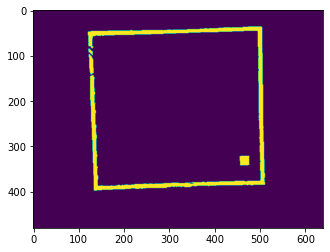

Picture of thymio with computed center represented by a green dot


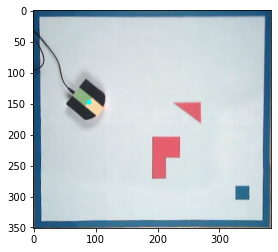

Resized map from the blue mask


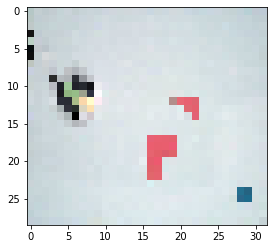

Result of the red mask


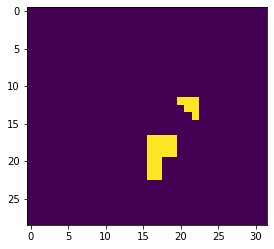

Thymio position in centimeters and degrees from the bottom left corner:
Thymio x:  17.5 [cm] Thymio y:  42.3 [cm] Thymio theta:  -40.1 [degrees]

Goal coordinate in grid referential:
Goal x:  29 [squares] Goal y:  4 [squares]


In [2]:
pose, image = record_project()
obstacles, goal_coor = localize(image)
print("Thymio position in centimeters and degrees from the bottom left corner:")
print("Thymio x: ", round(pose[0],1),"[cm]", "Thymio y: ", round(pose[1],1),"[cm]", "Thymio theta: ",round(pose[2],1)-90,"[degrees]")
print("")
print("Goal coordinate in grid referential:")
print("Goal x: ", goal_coor[0],"[squares]", "Goal y: ",goal_coor[1],"[squares]")

# Global Navigation 

In this part, we implemented the A* algorithm to allow Thymio to go to the goal position while avoiding the 2D global obstacles and without using its sensors to detect them.
In order to do that, we used the goal position, Thymio's pose and the grid map containing information about the position of the global obstacles given by the vision algorithm.

The following plot shows the grid map with the global obstacles (red polygons) given by the vision algorithm:

Text(0, 0.5, 'y-axis')

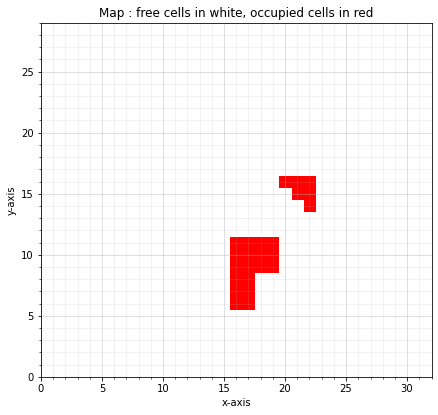

In [3]:
# change to the right coordinate format
occupancy_grid = (np.flipud(obstacles)).transpose()
fig, ax = display_map(occupancy_grid.transpose())
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")

To ease the implementation of the A* algorithm, we increased the size of the obstacles by the radius of the robot (circa 3 squares in the grid map), so that we can consider the robot as a point in the path planning algorithm. 

The following plot shows the grid map with obstacles increased by 3 squares:

Text(0, 0.5, 'y-axis')

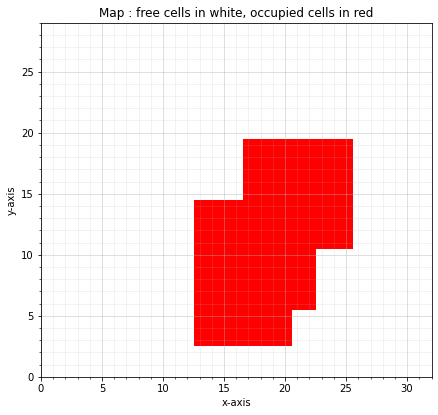

In [4]:
# increase obstacles
final_occupancy_grid = increased_obstacles_map(occupancy_grid)
fig, ax = display_map(final_occupancy_grid.transpose())
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")

## A* algorithm 
The A* algorithm expandes the node n with the smallest $f(n) = g(n) + h(n)$, where $g(n)$ denotes the cheapest path cost from the starting node and $h(n)$ the heuristic function.

We decided to use the A* algorithm to find the optimal path to the goal, because if $h(n)$ is a consistent heuristic, then A* is optimally efficient among all optimal search algorithms using $h(n)$. No other optimal algorithm using $h(n)$ is guaranteed to expand fewer nodes than A*. $h(n)$ is consistent if the $f(n)$ costs are non-decreasing : $f(n_j)\geq f(n_i) $ (going from a node i to a node j). 

The heuristic function has been chosen to be the estimate of the cost to reach the goal from node n (in a straight line and without considering the obstacles). This specific heuristic function is consistant, because $h(n_i)\geq cost(n_i, n_j)+h(n_j)$, therefore, A* is optimally efficient. 

The following figure shows an example of the implementation of such an algorithm in a map with increased obstacles:

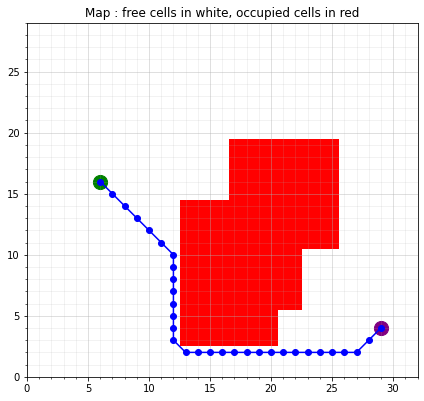

In [5]:
# Define the start and end goal
start = (round(pose[0]/2.5-1),round(pose[1]/2.5)-1)
goal = goal_coor

# Run the A* algorithm    
path = A_Star(start, goal, final_occupancy_grid)
path = np.array(path).reshape(-1, 2).transpose()
display_global_path(start, goal, path, final_occupancy_grid.transpose())


- The white cells represent free cells
- The red cells represent occupied cells (global obstacles)
- The blue nodes are the nodes corresponding to the optimal path
- The green circle represent the starting node
- The purple circle represents the goal node



# Motion Control 

We have two different motion control algorithms:
- The first one is used in the local navigation module and describes relative displacements. Indeed, in the local avoidance algorithm, we programmed Thymio to move a certain distance (usually 1 square or 4 squares of the grid map) and rotate a certain amount (usually 5 or 30 degrees). In order to do so, the robot travels a distance or rotates a certain amount of time, calculated with two constants. The displacement constant is the time required to move forward by 1 cm with a speed of 100 in Thymio's units. The rotation constant is the time required to rotate by 180 degrees with a speed of 100 in Thymio's units. Hence, the desired displacement and rotation are ratios of these constants.
- The second one is used in the main program and describes absolute displacements. Every displacement is decomposed into two steps: first rotation and then displacement. At each time step (100 ms), we calculate the position of the robot using the Kalman filter and from this position, we compute a set of commands (rotation + displacement) to give to the robot for it to reach the next point in the path.

In order to have a smoother displacement, we reduced the number of points in the global path by extracting its corners as follows:

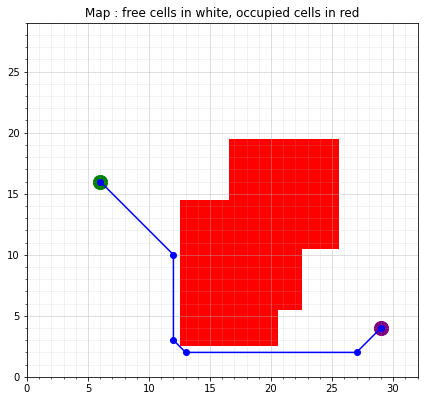

In [6]:
points = full_path_to_points(path)
display_global_path(start, goal, points, final_occupancy_grid.transpose())

Furthermore, regarding this second control algorithm, we imposed a condition on the rotation and the displacement, so that the robot does not do too small movements.
In the following drawing, $\Delta_\theta$ is the angle of the robot with respect to the target point, and $\Delta_r$ is the distance between the robot's position and the target point. If $\Delta_\theta < \epsilon_\theta$, the robot doesn't rotate and if $\Delta_r < \epsilon_r$, the robot doesn't move forward. 



![epsilon](epsilon.jpeg)

Once the rotation and the displacement are done, the target point is assumed to be reached, and the robot will move towards the next target (i.e next point in the path containing only the corners of the global path). This procedure is repeated until all the points in the path containing the corners of the global path are reached and, hence, the robot reaches the goal position.

# Filtering : EKF 

The objective of this part is to estimate the position of the robot from noisy sensors measurements (odometry and vision). To do this, we decided to use an extended kalman filter (EKF).

## Control model

We started by defining the discrete-time state-space model $x_{t+1} = f(x_t, u_t)$ where the state $x_t$ was a vector representing the position of the robot (2D position and orientation), i.e. $x_t =  \begin{bmatrix} x_t\\ y_t\\\theta_t  \end{bmatrix}$, and $u_t$ denote the control input (here the reading from a proprioceptive sensor). Hence, $u_t$ can be written as $u_t =  \begin{bmatrix} \Delta_{s_r}\\ \Delta_{s_l}  \end{bmatrix}$, where $\Delta_{s_r}$ and $\Delta_{s_l}$ are determined using the encoder readings of the right and left wheel.

Furthermore, let's define some useful variables


- $\Delta_{s_r}$ : travelled distance for the right wheel 
- $\Delta_{s_l}$ : travelled distance for the left wheel 
- $\Delta s = \frac{\Delta_{s_r} + \Delta_{s_l}}{2}$ : mean of the travelled distance
- $(\Delta x, \Delta y, \Delta \theta)$ : path travelled in the last sampling interval of fixed length $T_s = 100ms$
- $\Delta \theta = \frac{\Delta_{s_r} - \Delta_{s_l}}{b}$ 
- $b$ : the distance between the two wheels of the differential drive robot 

$x_{t+1}= f(x_t, u_t) = f(x_t, y_t, \theta_t, \Delta_{s_r}, \Delta_{s_l}) =  \begin{bmatrix} x_{t+1}\\ y_{t+1}\\\theta_{t+1}  \end{bmatrix} = \begin{bmatrix} x_t + \Delta_s cos(\theta_t + \frac{\Delta \theta}{2})\\ y_t + \Delta_s sin(\theta_t + \frac{\Delta \theta}{2}) \\ \theta_t + \Delta \theta  \end{bmatrix}$
 

Since $f(x_t, u_t)$ is a non-linear function, we linearize it around the point ($\mu_{x_t}$,$\mu_{u_t}$). In order to do so, we needed to calculate the following two jacobian matrices:

$F_x = \left.\frac{\partial f(x_t, u_t)}{\partial x_t} \right|_{(\mu_{x_t},\mu_{u_t})} = \begin{bmatrix} 
1 & 0 & -\Delta_s sin(\theta_t + \frac{\Delta \theta}{2}) \\ 
0 & 1 & \Delta_s cos(\theta_t + \frac{\Delta \theta}{2})\\ 
0 & 0 & 1
\end{bmatrix}$

$F_u = \left.\frac{\partial f(x_t, u_t)}{\partial u_t} \right|_{(\mu_{x_t},\mu_{u_t})} = \begin{bmatrix} 
\frac{1}{2} cos(\theta_t + \frac{\Delta \theta}{2}) - \frac{\Delta_s}{2b} sin(\theta_t + \frac{\Delta \theta}{2}) & \frac{1}{2} cos(\theta_t + \frac{\Delta \theta}{2}) + \frac{\Delta_s}{2b} sin(\theta_t + \frac{\Delta \theta}{2}) \\ 
\frac{1}{2} sin(\theta_t + \frac{\Delta \theta}{2}) + \frac{\Delta_s}{2b} cos(\theta_t + \frac{\Delta \theta}{2}) & \frac{1}{2} sin(\theta_t + \frac{\Delta \theta}{2}) - \frac{\Delta_s}{2b} cos(\theta_t + \frac{\Delta \theta}{2}) \\
\frac{1}{b} & - \frac{1}{b}
\end{bmatrix}$



The control input had an associated covariance matrix $R= \begin{bmatrix} k_r  & 0\\ 0 & k_l  \end{bmatrix}$, where $k_r$ and $k_l$ are constants to be determined experimentally. 

In order to determine these constants, we measured the time Thymio took to travel a known distance, while recording the speed values in Thymio units. From these measurements we computed: $k_r = 2.5 \cdot 10^{-2} m$ and $k_l = 1.5 \cdot 10^{-2} m$.


The prediction step is:
- $\overline{\mu}_{t} = f(\mu_{x_{t-1}},\mu_{u_{t-1}})$
- $\overline{\Sigma}_{t} = F_x \Sigma_{t-1} F_x^T + F_u R F_u^T$


## Measurement model


We chose the measurement model to be the following :

$y_t = H_t x_t + \epsilon_t = \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0\\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_t\\ y_t\\\theta_t  \end{bmatrix} + \epsilon_t$, where $\epsilon_t$ is the measurment noise with zero mean and covariance $Q = \begin{bmatrix} q_x & 0 & 0\\ 0 & q_y & 0 \\ 0 & 0 & q_{\theta}  \end{bmatrix} $, where $q_x$, $q_y$ and $q_t$ are constants to be determined experimentally.

In order to determine these constants, we measured several known positions of Thymio using the camera. From these measurements we computed: $q_x = 2.8948 \cdot 10^{-4} m$, $q_y = 8.2668 \cdot 10^{-4} m$ and $q_{\theta} = 0.0029 rad$.


$z_t = \begin{bmatrix} z_{x_t}\\ z_{y_t}\\ z_{\theta_t}  \end{bmatrix}$ is the reading from the camera (exteroceptive sensor), also called the observation.

The kalman gain is defined as $K_t = \overline{\Sigma}_{t}H_t^T(H_t \overline{\Sigma}_{t} H_t^T + Q)^{-1} = \overline{\Sigma}_{t}( \overline{\Sigma}_{t} + Q)^{-1}$. 

Hence, the updated step is :
- $\mu_{t} = \overline{\mu}_{t} + K_t(z_t - \overline{\mu}_{t})$
- $\Sigma_{t} = (I-K_tH_t) \overline{\Sigma}_{t} = (I-K_t) \overline{\Sigma}_{t}$

## Scenarios

In this part, we will present three scenarios to explain how the Kalman filter works:
- The first one will use only the odometry data to localize the robot. Therefore, we will implement only the prediction step of the kalman filter.
- The second one will use the odometry data and the camera data to localize the robot. Therefore, we will implement the prediction and the update step of the kalman filter.
- The third one will show the effect of the estimate of the starting position on the robot's behaviour. 

In these scenarios, we will plot the position uncertainy as an ellipse, whose axis are the square root of the eigenvalues of the covariance matrix of the position of the robot.

### First scenario: prediction only 

In this section, we will demonstrated that if we use only the odometry data, the robot is very uncertain about his current position. (i.e huge covariance matrix)


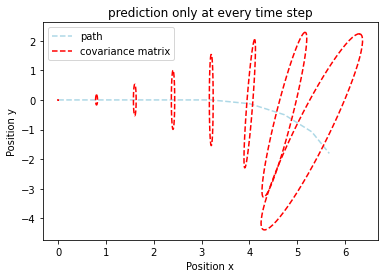

In [7]:
# initial position of the robot is unknown 
state_pred = [np.array([[0], [0], [0]])]
cov_pred = [0.01 * np.ones([3,3])]

# odometry data 
delta_sl = [0.8, 0.8, 0.8, 0.8, 0.83, 0.83, 0.83, 0.83]
delta_sr = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

# kalman filter: prediction only 
for i in range(len(delta_sr)):
    
    new_state_pred, new_cov_pred = prediction_only(state_pred[-1], cov_pred[-1], delta_sr[i], delta_sl[i])
        
    state_pred.append(new_state_pred)
    cov_pred.append(new_cov_pred)

# display the robot path in blue and its position uncertainy is displayed in red
plt.plot([x[0][0] for x in state_pred], [x[1][0] for x in state_pred], "--r", color='lightblue', label="path")

# compute the representation of the covariance 
for i in range(len(delta_sr)):
    px, py = plot_covariance_ellipse(state_pred[i], cov_pred[i]/1000)
    if i == 0:
        plt.plot(px, py, "--r", label="covariance matrix")
    plt.plot(px, py, "--r")

plt.xlabel("Position x")
plt.ylabel("Position y")
plt.title("prediction only at every time step")
plt.legend()

As we can see, as Thymio moves, it's more and more uncertain about its localization.

### Second scenario: prediction and update 

In this section, we will demonstrate the effects of integrating a measurement coming from the camera on Thymio's knowledge of his localization.

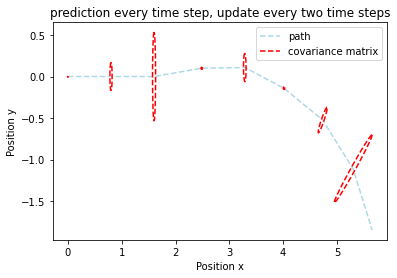

In [8]:
# initial position of the robot is unknown 
state_est = [np.array([[0], [0], [0]])]
cov_est = [0.01 * np.ones([3,3])]

# measurements 
z1 = np.array([[2.5], [0.1], [0.01]])   # true position is (2.4, 0, 0)         // i == 2
z2 = np.array([[4], [-0.14], [-0.33]])  # true position is (4, -0.12, -0.32)   // i == 4
z3 = np.array([[5.2], [-1.1], [-0.9]])  # true position is (5.3, -1.07, -0.95) // i == 6
z = [z1, z2, z3]

meas = 0
# kalman filter: prediction and update 
for i in range(len(delta_sr)):
    
    if i == 2:
        meas = 0    
    if i == 4:
        meas = 1
    if i == 6:
        meas = 2
    new_state_est, new_cov_est = kalman_filter_with_indices(i, z[meas], state_est[-1], cov_est[-1], delta_sr[i], delta_sl[i])

    state_est.append(new_state_est)
    cov_est.append(new_cov_est)
    
       
# display the robot path in blue and its position uncertainy is displayed in red
plt.plot([x[0][0] for x in state_est], [x[1][0] for x in state_est], "--r", color='lightblue', label="path")

for i in range(len(delta_sr)):
    px, py = plot_covariance_ellipse(state_est[i], cov_est[i]/1000)
    if i == 0:
        plt.plot(px, py, "--r", label="covariance matrix")
    plt.plot(px, py, "--r")

plt.xlabel("Position x")
plt.ylabel("Position y")
plt.title("prediction every time step, update every two time steps")
plt.legend()

As we can see, as Thymio moves it's more and more uncertain about its localization, but when we integrate the measurements (every two time steps), the uncertainty about its position decreases drastically.

### Third scenario

In this section, we will illustrate the effects of the estimation of the starting position on the robot's behaviour. 

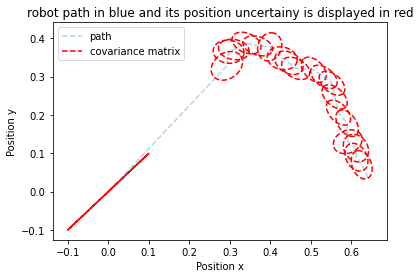

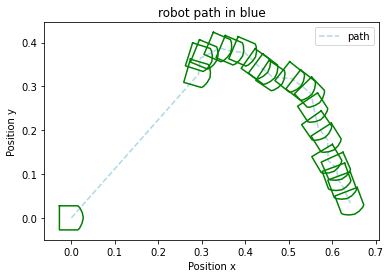

In [9]:
# initial position of the robot is unknown 
state_test = [np.array([[0], [0], [0]])]
cov_test = [1 * np.ones([3,3])]

# measurements and odometry data for scenario 3
delta_sr_test, delta_sl_test, z = get_param_scenario3()


for i in range(len(delta_sr_test)):

    new_state_test, new_cov_test = kalman_filter(z[i], state_test[-1], cov_test[-1], delta_sr_test[i], delta_sl_test[i])
    
    state_test.append(new_state_test)
    cov_test.append(new_cov_test)

# display the robot path in blue and its position uncertainy is displayed in red  
plt.plot([x[0][0] for x in state_test], [x[1][0] for x in state_test], "--r", color='lightblue', label="path")

for i in range(len(delta_sr_test)):
    px, py = plot_covariance_ellipse(state_test[i], cov_test[i]/100)
    if i == 0:
        plt.plot(px, py, "--r", label="covariance matrix")
    plt.plot(px, py, "--r")

plt.xlabel("Position x")
plt.ylabel("Position y")
plt.title("robot path in blue and its position uncertainy is displayed in red")
plt.legend()

# plot thymio on the path
overall_thymio_coords = []

for pos in state_test:
    
    rotated_thymio_coords = rotate_thymio(pos[2][0]-math.pi/2, thymio_coords/200)
    abs_Thymio_coords = rotated_thymio_coords+np.array([pos[0][0], pos[1][0]])
    overall_thymio_coords.append(abs_Thymio_coords)

plt.figure()
plt.plot([x[0][0] for x in state_test], [x[1][0] for x in state_test], "--r", color='lightblue', label="path")

for coords in overall_thymio_coords:
    plt.plot(coords[:,0], coords[:,1], color="g")
    
plt.xlabel("Position x")
plt.ylabel("Position y")
plt.title("robot path in blue")
plt.legend()

As we can see, the first covariance is much bigger than the next ones, because at the very beginning the robot has no idea where it might be. But, as Thymio moves, it's much more certain about its position, because we integrated the measurements at each time step using the kalman filter. From the second position estimate to the last position estimate, we can see that they are close the real positions of the robot.

In our project, we decided to initialize the robot's pose with the first camera measure, to avoid having to deal with this unnecessary uncertainty at the beginning.

# Local Navigation 

While navigating, Thymio uses its proximity sensors to avoid physical obstacles that can be put in its path at any point in time. Our obstacle avoidance algorithm works for rectangular parallelepipeds and cylinders. 

Once Thymio detects the local obstacle, our program immediatly enters in local navigation mode. The module "Local avoidance" is composed of
- one enum EventEnum (to determine the direction of avoidance) 
- one class ObstacleAvoidance 

The class ObstacleAvoidance contains all the code in order to avoid the obstacle. 

It begins by updating the path. In fact, when we enter the local avoidance we want to determine the remaining nodes of the global path from Thymio's actual position to the goal. The local function "_update_path" is in charge of this part and only keeps the nodes behind the local obstacle to the goal. 

The updated path is used as an exit condition to know when Thymio has to leave the local avoidance module. When Thymio crosses this updated path, the exit condition is fulfilled and the program comes back to the global navigation algorithm.

Then, based on its sensor readings, Thymio determines along which side of the local obstacle he will avoid it (this gives us the "avoidance direction": right or left):
- case 1: the robot sees a wall with both its right and left side sensors. He chooses then to follow the direction of the sensor with the smallest value.
- case 2: the robot sees a wall on its right side. He chooses then to avoid the obstacle along the left side of the local obstacle. 
- case 3: the robot sees a wall on its left side. He chooses then to avoid the obstacle along the right side of the local obstacle.
- case 4: the robot sees a wall only with its middle sensor. He chooses then to avoid the obstacle along the left side of the local obstacle by default.

![local nav](avoidance4cases.jpg)

Subsequently, the robot rotates on itself accordingly to the avoidance direction until the sensors do not see the obstacle anymore. From this operation Thymio ends up being parallel to the obstacle and starts to follow it (local function "_cote_avoid").

To follow the wall, we applied the following method:
- Thymio moves forward of a constant (ONE_STEP)
- it rotates by 30° to check if the obstacle is still next to itself

If he do not observe an obstacle:
- it rotates by -30°
- it continues this routine from the beginning

If he observes an obstacle:
- it rotates by -30°
- it moves forward of a constant (FOUR_STEPS) to avoid a possible corner of the obstacle
- it rotates until he observes the obstacle again
- it continues the routine from the beginning

At the same time, Thymio checks before it moves forward, if the advancement distance contains a limit of the map or a global obstacle in 2D. If it does, Thymio does a half turn (180°), changes the "avoidance direction" to the opposit direction and starts the routine again. (i.e he tries to avoid the local obstacle on the other side).

Meanwhile, Thymio checks if it will cross the updated path. If it does, Thymio begins its exit routine of the local avoidance to go back to the global navigation. The routine consists of updating the global path to remove all the remaining steps passed during the local avoidance. This new global path is then transmitted to the global navigation algorithm.


## Examples 

In this section, we presented two examples to illustrate this local avoidance algorithm.
- In the first example, Thymio changes its avoidance direction, because it reaches the limit of the map.
- In the second example, Thymio changes its avoidance direction, because an obstacle lies on its path.

### Example 1


In [10]:
frames, titles = get_frames_and_titles("obstacle.mov")
browse_images(frames, titles)

interactive(children=(IntSlider(value=51, description='i', max=101, min=1), Output()), _dom_classes=('widget-i…

Here is the analysis of the first example:

- frame 1 to 14 : global navigation
- frame 15 : Thymio detects the local obstacle and decides to avoid it by the right side
- frame 16 to 22 : the robot follows the wall of the obstacle
- frame 23 : Thymio detects the global obstacle in 2D
- frame 24 to 34 : the robot rotates by 180° to avoid the obstacle following the other direction
- frame 35 to 84 : Thymio follows the wall of the obstacle
- frame 84 : Thymio knows that he will cross the global path during the next displacement. The programm exits the local avoidance module
- frame 85 to 100 : global navigation
- frame 101 : Thymio arrives to the goal


### Example 2

In [ ]:
frames, titles = get_frames_and_titles("wall.mov")
browse_images(frames, titles)

Here is the analysis of the second example:

- frame 1 to 7 : global navigation
- frame 8 : Thymio detects the local obstacle and decides to avoid it by the right side
- frame 9 to 16 : the robot follows the wall of the obstacle
- frame 17 : Thymio detects the limit of the map
- frame 18 to 29 : Thymio do a half turn (180°) to avoid the obstacle from the other direction
- frame 30 to 136 : Thymio follows the wall of the obstacle
- frame 137 : Thymio knows that he will cross the global path during the next displacement. The program exits the local avoidance module.
- frame 138 to 165 : global navigation
- frame 166 : Thymio arrives to the goal

# Project Architecture

The whole architecture has evolved a lot over time. At first, we made kind of a multithreading program where different tasks where running in parallel, even though python is not multithreading at the execution. This approach didn't offer significant performances and just made the project too complex. Hence, we opted for a simpler case where we have a main thread where the robot executes different tasks based on its position and sensors. 
Using multithreading for every task would have resulted in a more complex code but with easier routine interruptions. Unfortunately multithreading in python has a lot of downsides, like for example not beeing able to delete threads manually and a way more complex code. The python interpreter is focused on making a safe code for the user thus, one of its characteristics is to run on a single thread, hence losing the purpose of multithreading performance. This architecture was working well but was way too complex to manage, that's why we finally decided to opt for the simpler architecture described previously.

## Program's routine

Our class EventHandler, in src/displacement/management.py, is the core class where all the events are managed. It manages when to call either the Kalman filter or the local handler or the global handler. In the constructor, we initialized the class variables, the map, the camera, the kalman filter, the position and path of the robot. 

At the beginning, the robot starts in the global handler. First of all, it checks if the EKF needs to be called. It has two ways to be called; only taking into account the odomerty measurement or both the odomerty and the vision measurement. To know which one needs to be called, two time intervals have been set and a timer is deciding which one will be called. We chose to call the kalman filter with the prediction step every 100 ms and to call the kalman filter with the prediction and the update step every second. After the type of EKF has been chosen, Thymio will check the next point of the path (i.e its new target point) and use it to compute the rotation and displacement needed ($\Delta_\theta$ and $\Delta_r$) from the current pose estimate the EKF computed.

When moving forward the robot checks if there is a local obstacle (3D obstacle) in front of it. If one of the front sensors value is bigger than the obstacle_threshold, the robot changes to the local_handler and starts the local obstacle avoidance routine. It does so until it reaches the original path again, as explained previously. The local handler will then return the updated path and the program goes back in the global_handler, where the robot follows the global navigation routine. In global avoidance mode, if the robot reaches a point of the path, it stops and removes the point from the path. As long as there are still points to reach in the path the function "__global_handler" will be called again. If the path is empty this means that the goal is reached and both Thymio and the code will stop.

### Kalman handler 

Finally, let us analyse the EKF in the file src/kalman/kalman_filter.py. The main class of this portion of the code is called Kalmanhandler, where the speeds, positions and useful variables are managed. The constructor initializes the Kalman class, the SensorHandler class and other useful class variables. The class offers the possibility to record on a parallel thread the speed when the function get_kalman() is called. 

Our first idea was to record all the Thymio's speeds between two calls of the EKF and take the mean in order to have a more accurate speed to calculate the distance travelled by each wheel. The problem with this approach was that the class Thymio was called too often and the maximum depth was reached before the robot was able to reach the goal. 
Hence, we decided to only select the actual speed of the robot when get_kalman() is called, instead of taking the mean over a time interval. Using this value of the speed of each wheel and using the time elapsed between the current EKF call and the previous one, the program computes the displacement achieved by each wheel of the robot ($\Delta_{s_l}$ and $\Delta_{s_r}$). From these displacements, the EKF can be called to update the estimate of the actual position of Thymio.

If the measurement timer is reached, a measurement is made. Before calling the function kalman_filter from the class Kalman, we convert the robot's position estimate to meters and the robot's orientation in radians, instead of centimeters and degrees (because the EKF needs the position of the robot in these specific units). After the EKF call, the pose estimate is then converted back to cm and degrees for better visualization. The file kalman_filter takes the previous position, camera values and covariance to compute the newly estimated position and covariance. The very first covariance is big and will, after a few calls, get smaller and possibly converge to the real value.

# Running the code

We've made our project using PyCharm but as we understood that the full code must be executable from the present notebook, we've added the following cells to take the code from github. However, as the code was entirely made on PyCharm, we 
recommand downloading the provided code and executing the file: main.py using any IDE running python code. Warning, the .env file must be changed in order to have the right coefficient correcting Thymio imperfections and the right port. This step is explained a few cells later. The following packages must be insalled in order to run the code: pyserial, python-dotenv, opencv-python, tqdm, matplotlib, numpy and ipywidgets.

The given .env file containing informations depending on the Thymio and the setup must be corrected to have the right port and coefficients. The file is located in the src folder. All the values must be changed according to your setup and Thymio specs.
The COM_PORT is the port where the Thymio is connected to the computer. All the other values are the values depending on the Thymio specs. Distance time is the distance travelled during one second at a Thymio's speed of 100. Half turn time is the needed time to do a half turn at a Thymio's speed of 100 as the name explains it. The scalling for each wheel is found by making the Thymio go in a straight line. We need to do this because both wheel dynamics are not exactly the same and so we need to be sure that one won't go faster or slower than the other one. The camera port is the place where the camera is connected. Finally, the speed to mm/s is the convertion factor between thymio speed and speed in millimeters per second.

If you desire to execute the code from the notebook, the following cells must be run.

In [12]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets python-dotenv pyserial
!jupyter nbextension enable --py widgetsnbextension

You should consider upgrading via the 'c:\users\cheva\anaconda3\python.exe -m pip install --upgrade pip' command.


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [13]:
!git clone https://github.com/KookaS/basics-mobile-robotics.git

fatal: destination path 'basics-mobile-robotics' already exists and is not an empty directory.


In [14]:
%cd basics-mobile-robotics

C:\Users\cheva\Desktop\Project\basics-mobile-robotics


Finally, the following cell runs the code in the present notebook. If you prefer to use (as recommended) another IDE, the file main.py must be executed.

In [15]:
!python main.py

Traceback (most recent call last):
  File "main.py", line 50, in <module>
    main()
  File "main.py", line 39, in main
    th = Thymio.serial(port=os.getenv("COM_PORT"), refreshing_rate=0.1)
  File "C:\Users\cheva\Desktop\Project\basics-mobile-robotics\src\thymio\Thymio.py", line 393, in serial
    th = Thymio(serial.Serial(port), node_id, refreshing_rate)
  File "C:\Users\cheva\anaconda3\lib\site-packages\serial\serialwin32.py", line 31, in __init__
    super(Serial, self).__init__(*args, **kwargs)
  File "C:\Users\cheva\anaconda3\lib\site-packages\serial\serialutil.py", line 240, in __init__
    self.open()
  File "C:\Users\cheva\anaconda3\lib\site-packages\serial\serialwin32.py", line 62, in open
    raise SerialException("could not open port {!r}: {!r}".format(self.portstr, ctypes.WinError()))
serial.serialutil.SerialException: could not open port '\\\\.\\COM10': FileNotFoundError(2, 'Le fichier spécifié est introuvable.', None, 2)
